In [ ]:
pip -q install qiskit

     |████████████████████████████████| 6.5 MB 34.5 MB/s 
     |████████████████████████████████| 18.0 MB 52.3 MB/s 
     |████████████████████████████████| 240 kB 70.7 MB/s 
     |████████████████████████████████| 200 kB 72.3 MB/s 
     |████████████████████████████████| 111 kB 65.5 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 1.6 MB 49.2 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 943 kB 59.5 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 3.6 MB 42.2 MB/s 
     |████████████████████████████████| 113 kB 59.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1

In [ ]:
pip -q install pylatexenc

     |████████████████████████████████| 162 kB 15.6 MB/s 


In [ ]:
pip -q install ibm_quantum_widgets

     |████████████████████████████████| 993 kB 31.2 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits import mplot3d
import mpl_toolkits.mplot3d.art3d as art3d
#warnings.filterwarnings('ignore', category=DeprecationWarning)

from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

import random

In [ ]:
def stateprep(x_train, y_train, x_test, d):

  """
  x_train: array of training features (n_samples, 2)
  y_train: array of binary training labels (n_samples, )
  x_test: array of test features (2, )
  d: number of control qubits. Generates 2^d transformations to training data
  """

  N = x_train.shape[0]

  control_reg = QuantumRegister(d, 'control')
  x_train_reg = QuantumRegister(N, 'x_train')
  y_train_reg = QuantumRegister(N, 'y_train')
  x_test_reg = QuantumRegister(1, 'x_test')
  prediction_reg = QuantumRegister(1, 'prediction')

  stateprep = QuantumCircuit(control_reg, x_train_reg, y_train_reg, x_test_reg, prediction_reg)

  #create uniform superposition of control qubits
  stateprep.h(control_reg)


  #initialize training data
  for i in range(x_train.shape[0]):
    stateprep.initialize(x_train[i]/np.linalg.norm(x_train[i]), i+d)

  for i in range(y_train.shape[0]):
    if y_train[i] == 1:
      stateprep.initialize([0, 1], i+d+x_train.shape[0])
    else:
      stateprep.initialize([1, 0], i+d+x_train.shape[0])

  #initialize test data
  stateprep.initialize(x_test/np.linalg.norm(x_test), d+2*N)


  stateprep.barrier()

  return stateprep

In [ ]:
def superposition_sampler(x_train, y_train, x_test, d):

  """
  x_train: array of training features
  y_train: array of binary training labels
  x_test: array of test features
  d: number of control qubits. Generates 2^d transformations to training data
  """
  N = x_train.shape[0]

  control_reg = QuantumRegister(d, 'control')
  x_train_reg = QuantumRegister(N, 'x_train')
  y_train_reg = QuantumRegister(N, 'y_train')
  x_test_reg = QuantumRegister(1, 'x_test')
  prediction_reg = QuantumRegister(1, 'prediction')

  sampler = QuantumCircuit(control_reg, x_train_reg, y_train_reg, x_test_reg, prediction_reg)

  for i in range(d):
    l, m, lp, mp = random.sample(range(0,N), 4)

    sampler.cswap(control_reg[i], x_train_reg[l], x_train_reg[m])
    sampler.cswap(control_reg[i], y_train_reg[l], y_train_reg[m])
    sampler.x(i)
    sampler.cswap(control_reg[i], x_train_reg[lp], x_train_reg[mp])
    sampler.cswap(control_reg[i], y_train_reg[lp], y_train_reg[mp])
    sampler.barrier()

  return sampler

In [ ]:
def cosine_classifier(N, d):

  """
  N: number of train samples
  d: number of control qubits. Generates 2^d transformations to training data
  """
  control_reg = QuantumRegister(d, 'control')
  x_train_reg = QuantumRegister(N, 'x_train')
  y_train_reg = QuantumRegister(N, 'y_train')
  x_test_reg = QuantumRegister(1, 'x_test')
  prediction_reg = QuantumRegister(1, 'prediction')

  f = QuantumCircuit(control_reg, x_train_reg, y_train_reg, x_test_reg, prediction_reg)
  f.h(prediction_reg[0])

  k = random.sample(range(0, N), 1)

  f.cswap(prediction_reg[0], x_train_reg[k], x_test_reg[0])
  f.h(prediction_reg[0])
  f.cx(y_train_reg[k], prediction_reg[0])
  f.barrier()
  
  return f

In [ ]:
def measure():
    
    prediction_reg = QuantumRegister(1, 'prediction')
    cr = ClassicalRegister(1, name = "cr")
    m = QuantumCircuit(prediction_reg, cr)
    m.measure(prediction_reg[0], cr[0])
    
    return m

In [ ]:
def plot_data(x_train, y_train, x_test):
    '''
    x_train: (n_samples, 2)
    y_train: (n_samples, )
    x_test: (2, )
    '''
    x_test = x_test[np.newaxis, :]
    x = np.concatenate((x_train, x_test), axis = 0)
    y = np.concatenate((y_train, np.asarray([-1])), axis = 0)
    
    data = pd.DataFrame(columns = ['x1', 'x2', 'y'])
    data['x1'] = x[:, 0]
    data['x2'] = x[:, 1]
    data['y'] = y
    
    sns.catplot(x='x1', y='x2', hue='y', data=data)
    
    return

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.


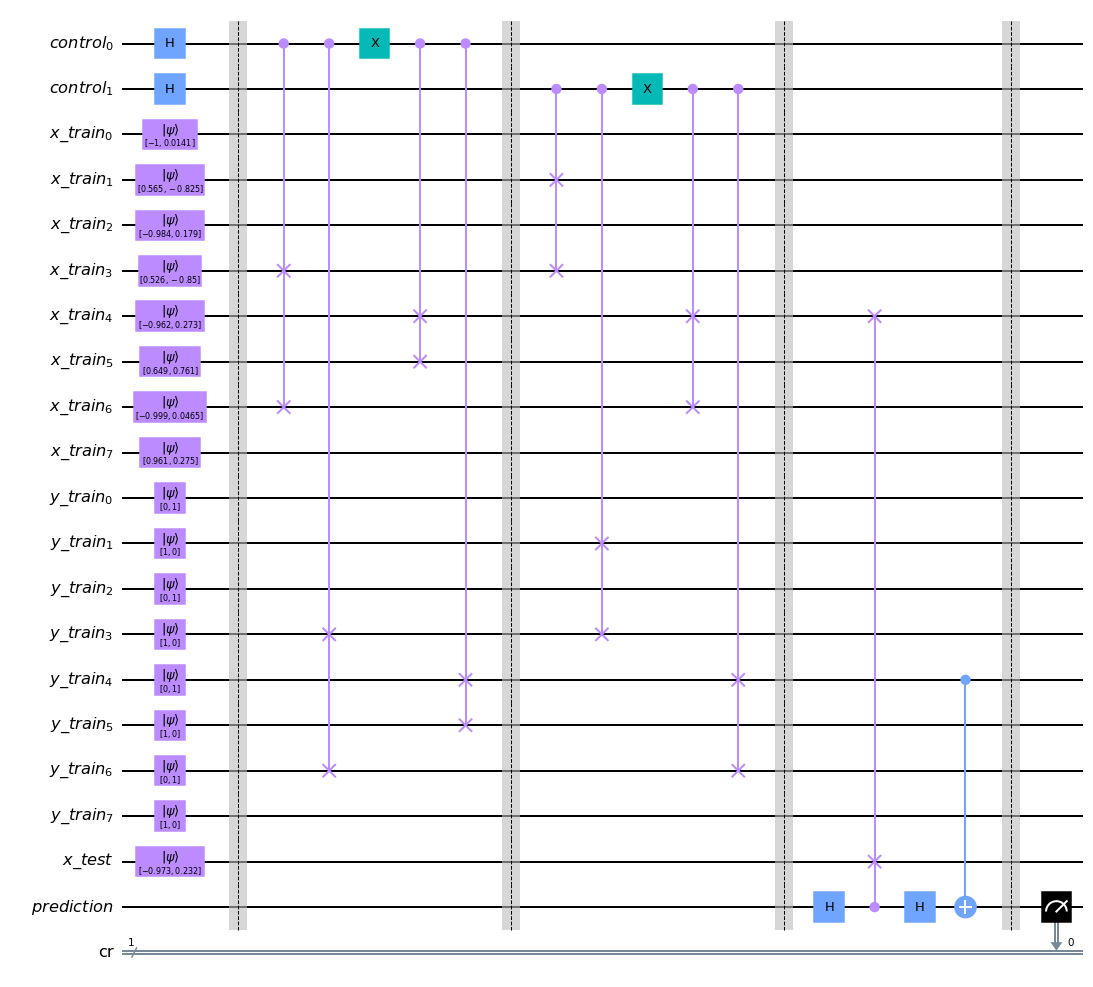

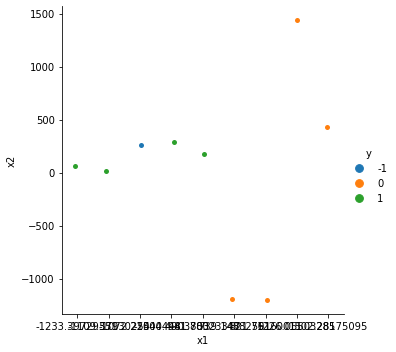

In [124]:
x_train = [[-1109.57930254,    15.64564125],
       [  821.76160011, -1200.97483261],
       [ -941.78023347,   171.8209733 ],
       [  739.14882591, -1194.80882602],
       [-1004.4903803 ,   285.07466299],
       [ 1226.05503285,  1436.05445621],
       [-1233.39729351,    57.38478307],
       [ 1502.28175095,   429.8031418 ]]
x_train = np.asarray(x_train)

y_train = [ True, False,  True, False,  True, False,  True, False]
y_train = np.asarray(y_train)

x_test = [-1072.22540448,  255.76658471]

x_test = np.asarray(x_test)

plot_data(x_train, y_train, x_test)



d = 2

N = x_train.shape[0]

circ = stateprep(x_train, y_train, x_test, d) 
circ += superposition_sampler(x_train, y_train, x_test, d)
circ += cosine_classifier(N, d)
circ += measure()
circ.draw(output='mpl')

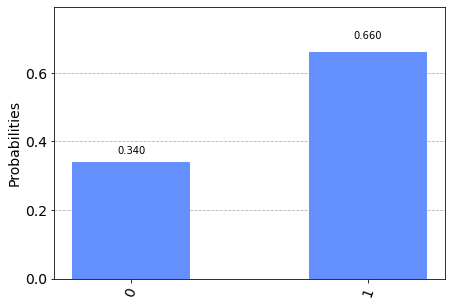

In [137]:
# train and predict
plot_histogram(execute(circ, Aer.get_backend('qasm_simulator'), shots=50).result().get_counts())

Prediction on MNIST dataset:

In [ ]:
from keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

Processing data:

In [319]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

filter_train = (train_y == 9) + (train_y == 0)
train_y = train_y[filter_train]
train_X = train_X[filter_train]

train_y = (train_y == 9)
test_y = (test_y == 9)

train_sample_sz = 8

accumulated_sz = 0
ones_count = 0
zeros_count = 0
new_train_y = []
new_train_x = []

while(accumulated_sz < train_sample_sz):
  idx = np.random.randint(0, train_X.shape[0], 1)
  x = train_X[idx]
  y = train_y[idx]
  if(ones_count > zeros_count and y == 0):
    new_train_y.append(y)
    new_train_x.append(x)
    accumulated_sz += 1
    zeros_count += 1
  elif(zeros_count > ones_count and y == 1):
    new_train_y.append(y)
    new_train_x.append(x)
    accumulated_sz += 1
    ones_count += 1
  elif(zeros_count == ones_count):
    if y==1: ones_count += 1
    else: zeros_count += 1
    new_train_y.append(y)
    new_train_x.append(x)
    accumulated_sz += 1

train_X = np.array(new_train_x)
train_y = np.array(new_train_y).reshape(train_sample_sz)

train_X = train_X.reshape(train_X.shape[0], -1)



filter_test = (test_y == 9) + (test_y == 0)
test_y = test_y[filter_test]
test_X = test_X[filter_test]
test_X = test_X.reshape(test_X.shape[0], -1)

pca = PCA(n_components = 2, svd_solver='full')
pca.fit(train_X)
train_X = pca.transform(train_X)

pca.fit(test_X)
test_X = pca.transform(test_X)


In [323]:
d = 2

N = train_X.shape[0]


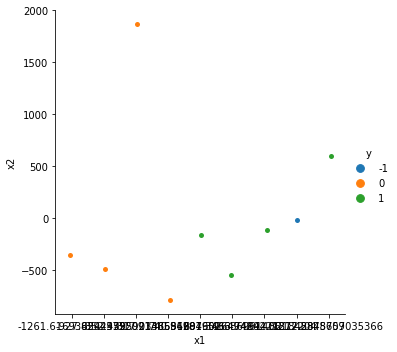

In [324]:
i = 10
plot_data(train_X, train_y, test_X[i])

In [325]:
test_y[i]

False

In [326]:
circ = stateprep(train_X, train_y, test_X[i], d)
circ += superposition_sampler(train_X, train_y, test_X, d) 
circ += cosine_classifier(N, d)
circ += measure()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  after removing the cwd from sys.path.


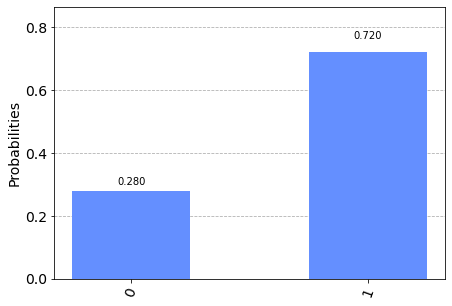

In [335]:
plot_histogram(execute(circ, Aer.get_backend('qasm_simulator'), shots=50).result().get_counts())